<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/medical_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医療スコア
- input
    - hospital_master.cav
        - 病院の位置とレーティング
    - pharmacy_nearby.csv
        - 薬局の位置とレーティング
- output
    - mecical_score.csv
        - 医療スコア

In [1]:
!pip install -q japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_score_file = 'medical_score.csv'

### 病院

In [6]:
df_hospital_master = pd.read_csv(os.path.join(DIR_NAME, 'hospital_master.csv'))[['名称', '小児', '妊婦', '緯度', '経度', 'rating']]
df_hospital_master['施設分類'] = '病院'
df_hospital_master.loc[df_hospital_master['rating'] == 0, 'rating'] = np.NaN
print(df_hospital_master.shape)

(3571, 7)


In [7]:
df_hospital_master.head()

,名称,小児,妊婦,緯度,経度,rating,施設分類
0,メディカクリニック,1.0,1.0,35.694355,139.762639,3.6,病院
1,九段坂内科消化器内科クリニック,NaN,NaN,35.696069,139.754469,4.2,病院
2,医療法人社団平晴会晴海3丁目クリニック,NaN,NaN,35.654056,139.779257,4.7,病院
3,文京春日こどもクリニック,2.0,NaN,35.710461,139.752461,4.2,病院
4,蔵前まえだクリニック,NaN,NaN,35.706362,139.789713,4.6,病院


### 薬局

In [8]:
df_pharmacy_master = pd.read_csv(os.path.join(DIR_NAME, 'pharmacy_nearby.csv'))[
    ['name', 'lat', 'lng', 'rating']
].rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
df_pharmacy_master['施設分類'] = '薬局'
df_pharmacy_master.loc[df_pharmacy_master['rating'] == 0, 'rating'] = np.NaN
print(df_pharmacy_master.shape)

(5980, 5)


In [9]:
df_pharmacy_master.head()

,名称,緯度,経度,rating,施設分類
0,日本調剤㈱,35.681553,139.769161,2.5,薬局
1,アイン薬局 グランスタ丸の内店,35.682737,139.766298,4.0,薬局
2,ココカラファイン ヤエチカ北口店,35.681502,139.769801,3.1,薬局
3,ココカラファイン薬局 ヤエチカ北口店,35.681495,139.769810,3.7,薬局
4,ウエルシア東京ミッドタウン八重洲店 (調剤薬局),35.679466,139.769185,3.0,薬局


### 地理マスタ

In [14]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [11]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [12]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

## 医療スコア

In [15]:
%%time
# 近い5件の距離の平均
df_geo_master['病院(平均距離)'] = get_value_of_nearest_facility(df_geo_master, df_hospital_master, '病院', 'mean', 5)
# 0.5km以内の施設の数
df_geo_master['病院(数)'] = get_value_of_nearest_facility(df_geo_master, df_hospital_master, '病院', 'count', 0.5)

df_pediatrics = df_hospital_master[df_hospital_master['小児'].notna()]
# 近い3件の距離の距離
df_geo_master['小児科(平均距離)'] = get_value_of_nearest_facility(df_geo_master, df_pediatrics, '病院', 'mean', 3)
# 0.5km以内の施設の数
df_geo_master['小児科(数)'] = get_value_of_nearest_facility(df_geo_master, df_pediatrics, '病院', 'count', 0.5)

# 近い3件の距離の平均
df_geo_master['薬局(平均距離)'] = get_value_of_nearest_facility(df_geo_master, df_pharmacy_master, '薬局', 'mean', 3)
# 0.5km以内の施設の数
df_geo_master['薬局(数)'] = get_value_of_nearest_facility(df_geo_master, df_pharmacy_master, '薬局', 'count', 0.5)

病院 not found 1050
病院 not found 1354
病院 not found 1357
病院 not found 2830
病院 not found 1050
病院 not found 1354
病院 not found 1357
病院 not found 2830
病院 not found 1050
病院 not found 1354
病院 not found 1357
病院 not found 2830
病院 not found 1050
病院 not found 1354
病院 not found 1357
病院 not found 2830
薬局 not found 1050
薬局 not found 1354
薬局 not found 1357
薬局 not found 2830
薬局 not found 1050
薬局 not found 1354
薬局 not found 1357
薬局 not found 2830
CPU times: user 2min 12s, sys: 947 ms, total: 2min 13s
Wall time: 2min 13s


In [16]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 12)


,town_id,市区町村名,町名,町丁目,緯度,経度,病院(平均距離),病院(数),小児科(平均距離),小児科(数),薬局(平均距離),薬局(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0.272744,8.0,0.248029,4.0,0.188747,13.0
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0.471440,2.0,0.421505,2.0,0.332412,3.0
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.255231,11.0,0.316020,3.0,0.196463,12.0
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0.151833,8.0,0.398820,2.0,0.098016,13.0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0.239392,12.0,0.414488,3.0,0.160808,17.0


### 病院スコア

In [17]:
all_feature_list = []
all_score_list = []

In [18]:
score_name = '病院スコア'
feature_list = {
    '病院(平均距離)':   {'sort': -1, 'weight': 1}, 
    '病院(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

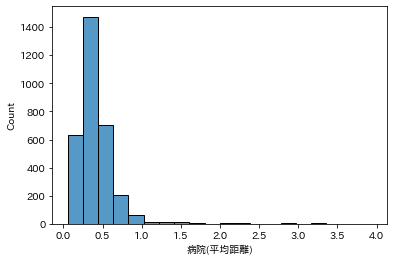

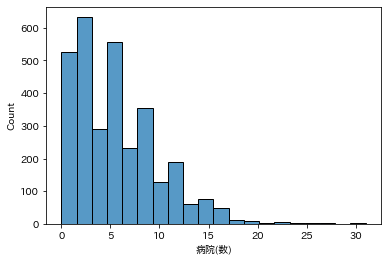

In [19]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [20]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

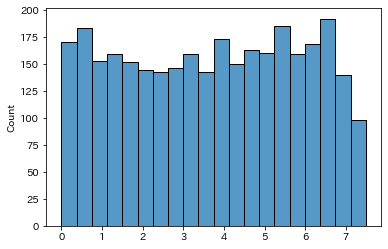

In [21]:
sns.histplot(_tmp_score, bins=20)
plt.show()

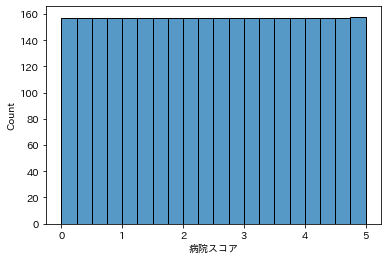

In [22]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [23]:
df_geo_master[score_name].describe()

count    3141.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 病院スコア, dtype: float64

### 小児科スコア

In [24]:
score_name = '小児科スコア'
feature_list = {
    '小児科(平均距離)':   {'sort': -1, 'weight': 1}, 
    '小児科(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

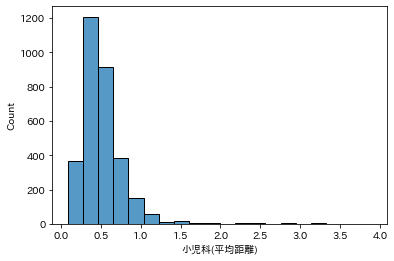

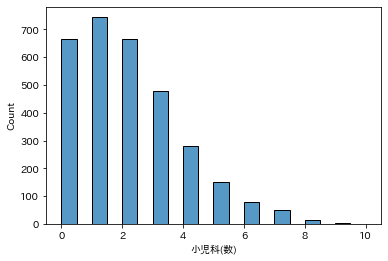

In [25]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [26]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

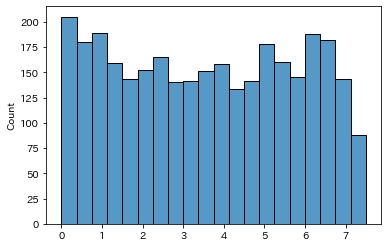

In [27]:
sns.histplot(_tmp_score, bins=20)
plt.show()

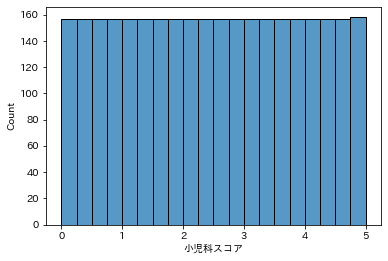

In [28]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [29]:
df_geo_master[score_name].describe()

count    3141.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 小児科スコア, dtype: float64

### 薬局スコア

In [30]:
score_name = '薬局スコア'
feature_list = {
    '薬局(平均距離)':   {'sort': -1, 'weight': 1}, 
    '薬局(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

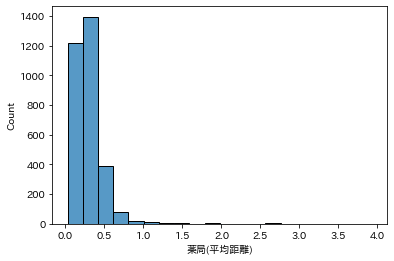

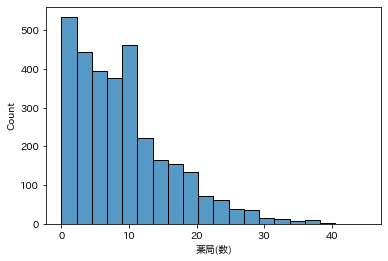

In [31]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [32]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

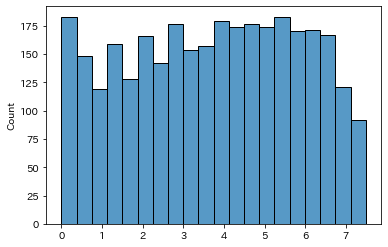

In [33]:
sns.histplot(_tmp_score, bins=20)
plt.show()

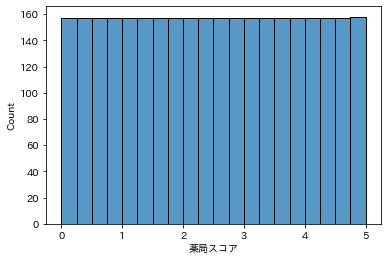

In [34]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [35]:
df_geo_master[score_name].describe()

count    3141.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 薬局スコア, dtype: float64

### 医療スコア

In [36]:
score_name = '医療スコア'
feature_list = {
    '病院スコア':   {'sort': 1, 'weight': 1}, 
    '小児科スコア': {'sort': 1, 'weight': 1},
    '薬局スコア':   {'sort': 1, 'weight': 1},
}
all_score_list.append(score_name)

In [37]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

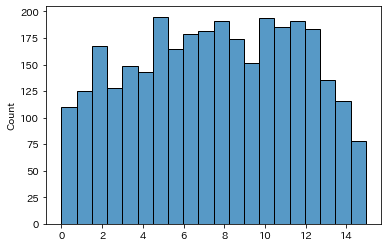

In [38]:
sns.histplot(_tmp_score, bins=20)
plt.show()

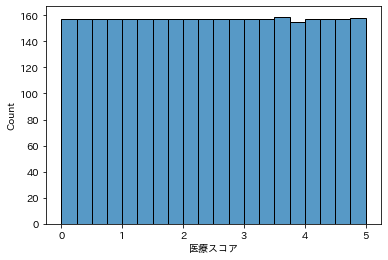

In [39]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [40]:
df_geo_master[score_name].describe()

count    3141.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.749204
max         5.000000
Name: 医療スコア, dtype: float64

### 保存

In [41]:
all_feature_list

['病院(平均距離)', '病院(数)', '小児科(平均距離)', '小児科(数)', '薬局(平均距離)', '薬局(数)']

In [42]:
all_score_list

['病院スコア', '小児科スコア', '薬局スコア', '医療スコア']

In [43]:
for col in [col for col in all_feature_list if '距離' in col]:
    df_geo_master[col] = df_geo_master[col].round(3)

for col in all_score_list:
    df_geo_master[col] = df_geo_master[col].round(2)

### 保存

In [44]:
df_geo_master[
    ['town_id'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

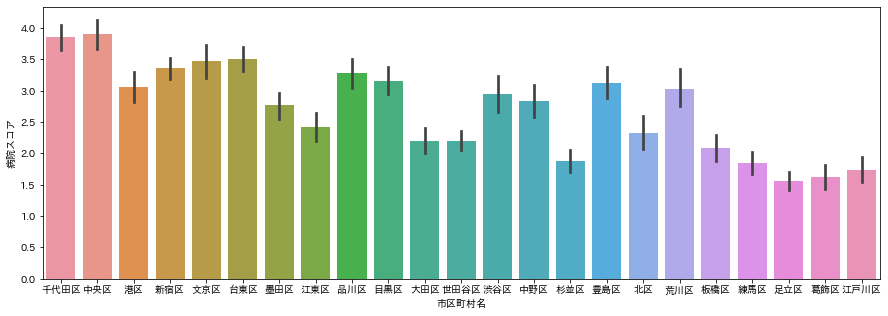

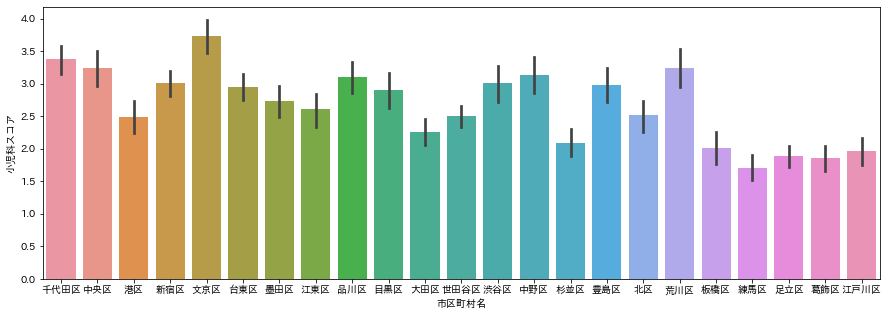

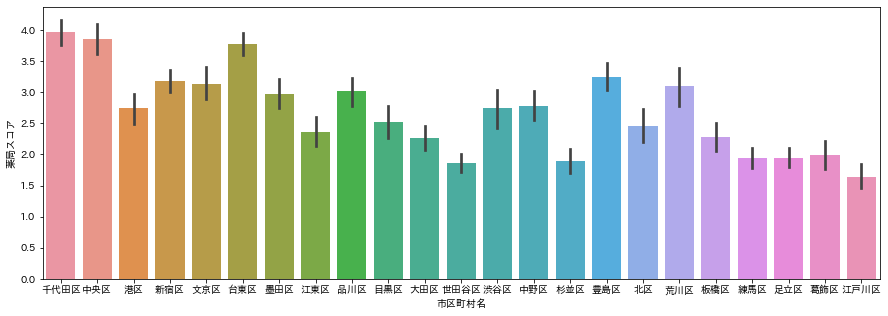

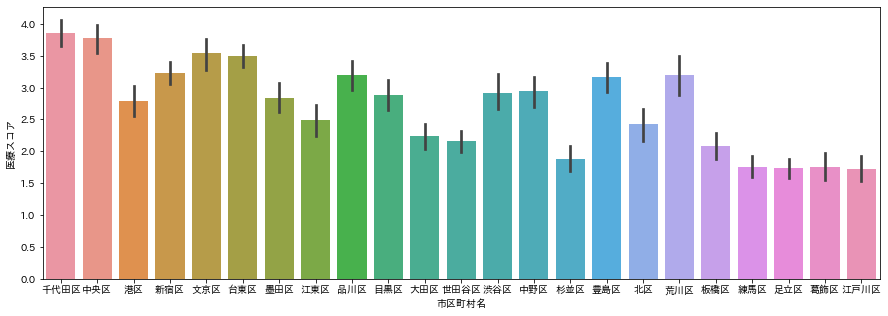

In [45]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_geo_master)
    plt.show()

In [46]:
def get_score_top(df_data, target, ):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [47]:
df_level = get_score_top(df_geo_master, '病院')
print(df_level.shape)
df_level.head(10)

(907, 6)


,市区町村名,町名,町丁目,病院(平均距離),病院(数),病院スコア
0,渋谷区,道玄坂,道玄坂２丁目,0.076,20.0,5.00
1,千代田区,内幸町,内幸町２丁目,0.100,24.0,5.00
2,中央区,銀座,銀座１丁目,0.108,22.0,5.00
3,港区,新橋,新橋２丁目,0.054,25.0,5.00
4,港区,西新橋,西新橋１丁目,0.123,30.0,4.99
5,江戸川区,西葛西,西葛西６丁目,0.088,17.0,4.99
6,港区,虎ノ門,虎ノ門１丁目,0.123,22.0,4.99
7,品川区,大井,大井１丁目,0.103,18.0,4.99
8,練馬区,豊玉北,豊玉北５丁目,0.120,17.0,4.98
9,北区,赤羽,赤羽２丁目,0.091,15.0,4.98


In [48]:
df_level.tail(10)

,市区町村名,町名,町丁目,病院(平均距離),病院(数),病院スコア
897,千代田区,千代田,千代田,0.904,0.0,0.13
898,大田区,昭和島,昭和島１丁目,0.934,0.0,0.12
899,江戸川区,東篠崎町,東篠崎町,0.958,0.0,0.11
900,足立区,神明,神明１丁目,0.995,0.0,0.10
901,江東区,夢の島,夢の島１丁目,1.320,0.0,0.07
902,品川区,東八潮,東八潮,1.360,0.0,0.07
903,大田区,東海,東海１丁目,1.505,0.0,0.05
904,大田区,京浜島,京浜島１丁目,1.759,0.0,0.04
905,大田区,城南島,城南島７丁目,2.732,0.0,0.02
906,江東区,若洲,若洲１丁目,3.166,0.0,0.01


In [49]:
df_level = get_score_top(df_geo_master, '小児科')
print(df_level.shape)
df_level.head(10)

(907, 6)


,市区町村名,町名,町丁目,小児科(平均距離),小児科(数),小児科スコア
0,文京区,小石川,小石川１丁目,0.130,8.0,5.00
1,渋谷区,道玄坂,道玄坂２丁目,0.083,10.0,5.00
2,江戸川区,一之江,一之江８丁目,0.096,8.0,5.00
3,新宿区,河田町,河田町,0.133,8.0,5.00
4,新宿区,改代町,改代町,0.134,7.0,4.99
5,江東区,豊洲,豊洲４丁目,0.125,7.0,4.99
6,江東区,東陽,東陽３丁目,0.145,8.0,4.99
7,港区,白金,白金１丁目,0.118,7.0,4.99
8,渋谷区,桜丘町,桜丘町,0.080,7.0,4.99
9,豊島区,南大塚,南大塚２丁目,0.164,8.0,4.99


In [50]:
df_level.tail(10)

,市区町村名,町名,町丁目,小児科(平均距離),小児科(数),小児科スコア
897,江東区,有明,有明２丁目,1.124,0.0,0.12
898,江東区,夢の島,夢の島２丁目,1.396,0.0,0.08
899,江戸川区,東篠崎町,東篠崎町,1.382,0.0,0.08
900,大田区,羽田空港,羽田空港１丁目,1.436,0.0,0.07
901,江東区,青海,青海１丁目,1.485,0.0,0.06
902,品川区,東八潮,東八潮,1.696,0.0,0.05
903,大田区,東海,東海１丁目,1.677,0.0,0.05
904,江東区,新木場,新木場１丁目,1.975,0.0,0.04
905,大田区,京浜島,京浜島１丁目,1.814,0.0,0.04
906,江東区,若洲,若洲１丁目,3.256,0.0,0.01


In [51]:
df_level = get_score_top(df_geo_master, '薬局')
print(df_level.shape)
df_level.head(10)

(903, 6)


,市区町村名,町名,町丁目,薬局(平均距離),薬局(数),薬局スコア
0,台東区,上野,上野６丁目,0.049,45.0,5.00
1,台東区,東上野,東上野２丁目,0.036,38.0,5.00
2,千代田区,鍛冶町,鍛冶町２丁目,0.067,33.0,4.99
3,千代田区,神田岩本町,神田岩本町,0.058,29.0,4.99
4,墨田区,錦糸,錦糸３丁目,0.046,28.0,4.99
5,豊島区,西池袋,西池袋１丁目,0.058,40.0,4.99
6,品川区,小山,小山４丁目,0.054,26.0,4.99
7,葛飾区,東金町,東金町１丁目,0.047,25.0,4.99
8,千代田区,神田美土代町,神田美土代町,0.062,29.0,4.98
9,千代田区,神田小川町,神田小川町１丁目,0.061,29.0,4.98


In [52]:
df_level.tail(10)

,市区町村名,町名,町丁目,薬局(平均距離),薬局(数),薬局スコア
893,足立区,舎人公園,舎人公園,0.703,0.0,0.13
894,渋谷区,代々木神園町,代々木神園町,0.691,0.0,0.13
895,葛飾区,水元公園,水元公園,0.763,0.0,0.10
896,大田区,昭和島,昭和島１丁目,0.777,0.0,0.10
897,世田谷区,砧公園,砧公園,0.842,0.0,0.09
898,千代田区,千代田,千代田,0.816,0.0,0.09
899,江東区,青海,青海１丁目,1.120,0.0,0.06
900,大田区,京浜島,京浜島１丁目,1.209,0.0,0.05
901,江東区,夢の島,夢の島１丁目,1.245,0.0,0.05
902,品川区,東八潮,東八潮,1.578,0.0,0.03


In [53]:
df_level = get_score_top(df_geo_master, '医療')
print(df_level.shape)
df_level.head(10)

(903, 4)


,市区町村名,町名,町丁目,医療スコア
0,渋谷区,道玄坂,道玄坂２丁目,5.00
1,台東区,上野,上野６丁目,5.00
2,豊島区,西池袋,西池袋１丁目,5.00
3,葛飾区,東金町,東金町１丁目,5.00
4,文京区,小石川,小石川１丁目,4.99
5,新宿区,改代町,改代町,4.99
6,墨田区,錦糸,錦糸３丁目,4.99
7,江戸川区,西葛西,西葛西６丁目,4.99
8,板橋区,成増,成増２丁目,4.99
9,北区,赤羽,赤羽２丁目,4.98


In [54]:
df_level.tail(10)

,市区町村名,町名,町丁目,医療スコア
893,江戸川区,東篠崎町,東篠崎町,0.14
894,千代田区,千代田,千代田,0.11
895,江東区,青海,青海１丁目,0.10
896,大田区,昭和島,昭和島１丁目,0.10
897,大田区,東海,東海３丁目,0.06
898,大田区,京浜島,京浜島１丁目,0.04
899,品川区,東八潮,東八潮,0.04
900,江東区,新木場,新木場１丁目,0.03
901,大田区,城南島,城南島７丁目,0.02
902,江東区,若洲,若洲１丁目,0.01
